In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [2]:
from objective_function import *
from optimiser import *

In [489]:
class adam(optimizer):
    def __init__(self):
        self.alpha = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-8
        self.max_iter = 10000
        self.tol = 1e-2
        
    def set_parameters(self, paras):
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta_1 = paras['beta_1']
        self.beta_2 = paras['beta_2']
        self.epsilon = paras['epsilon']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        
    def optimise(self, obj):
        m_t = 0 
        v_t = 0 
        t = 0
        x = self.x0
        while t < self.max_iter:					#till it gets converged
            t+=1
            g_t = obj.dfunc(x)		#computes the gradient of the stochastic function
            m_t = self.beta_1*m_t + (1-self.beta_1)*g_t	#updates the moving averages of the gradient
            v_t = self.beta_2*v_t + (1-self.beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(self.beta_1**t))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(self.beta_2**t))		#calculates the bias-corrected estimates
            x_prev = x								
            x = x - (self.alpha*m_cap)/(np.sqrt(v_cap)+self.epsilon)	#updates the parameters
            if(np.linalg.norm(x-x_prev) < 1e-5):		#checks if it is converged or not
                break
        return x, t
        

In [482]:
class line_search(adjust_optimizer):
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
    def set_parameters(self, paras):
        self.x0 = None if 'x0' not in paras.keys() else paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy().reshape(2,)
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 4
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            x += alpha_ * p
            fx = fnx
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if np.linalg.norm(p) < self.tol:
                break
        return x, eval_cnt

In [490]:
ad = adam()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':0.01, 'beta_1':0.9, 'beta_2':0.999, 'epsilon':1e-8, 'max_iter':100000, 'tol':1e-2}
ad.set_parameters(paras)
%time ad.optimise(ak)

CPU times: user 8.27 ms, sys: 1.29 ms, total: 9.56 ms
Wall time: 8.4 ms


(array([69.00004112, 81.99992652]), 153)

In [484]:
line = line_search()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
line.set_parameters(paras)
%time line.optimise(ak)

CPU times: user 1.45 ms, sys: 237 µs, total: 1.69 ms
Wall time: 1.52 ms


(array([69.00011095, 82.00007568]), 41)

In [488]:
l1 = line_search_1step()
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
l1.set_parameters(paras)
%time l1.optimise(ak)

CPU times: user 240 µs, sys: 38 µs, total: 278 µs
Wall time: 247 µs


(array([68.95310193, 81.96908965]), 8)

In [9]:
class post_analysis_multi():
    def __init__(self, points, res):
        self.points = points
        self.res = res
        self.num = self.res.shape[0]
    def plot_prob_vs_radius(self, *args):
        def count_global_min(res, points):        
            distance = np.linalg.norm(points, axis=1)
            idx = np.argsort(distance)
            dis_ascending = distance[idx]
            res_ascending = res[idx]
            prob = np.zeros((self.num, ))
            for i in range(self.num):
                prob[i] = np.sum(res_ascending[:i+1] == 1) / (i + 1) 
            return dis_ascending, prob
        argc = len(args)
        assert argc%2 == 0
        pair_cnt = int(argc / 2)
        dis_ascendings = np.zeros((self.num, pair_cnt + 1))
        probs = np.zeros((self.num, pair_cnt + 1))
        dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
        for i in range(pair_cnt):
            dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, np.max(dis_ascendings))
        ax.set_ylim(0, 2)
        ax.set_xlabel('distance from origin', fontsize=13)
        ax.set_ylabel('prob of global minminum', fontsize=13)
        for i in range(pair_cnt+1):
            ax.plot(dis_ascendings[:,i], probs[:,i])
        plt.show()

    def plot_cloud_point(self):
        fig = plt.figure(figsize=(7,7))
        '''
        # one quadrant
        x1 = np.hstack((self.points[:,0], self.points[:,1]))
        y1 = np.hstack((self.points[:,1], self.points[:,0]))
        res1 = np.hstack((self.res, self.res))
        # two qudrant
        x2 = np.hstack((x1, -x1))
        y2 = np.hstack((y1, y1))
        res2 = np.hstack((res1, res1))
        # four qudrant
        x = np.hstack((x2, -x2))
        y = np.hstack((y2, -y2))
        hue = np.hstack((res2, res2))
        '''
        x = self.points[:,0]
        y = self.points[:,1]
        hue = self.res
        p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp = single_experiment()
exp.set_objective(ak)


num = points.shape[0]
res = np.zeros((num, ))
for i in range(num):
    paras['mean0'] = points[i].reshape(2,1)
    cma.set_parameters(paras)
    exp.set_optimizer(cma)
    status = exp.do()
    if(status == 'global minimum'):
        res[i] = 1
    else:
        res[i] = 0

In [ ]:
class multiple_experiment:
    def __init__(self):
        self.single_exp = single_experiment()
    def set_objective(self, objective_func):
        self.single_exp.set_objective(objective_func)
    def set_optimizer(self, optimizer):
        self.single_exp.set_optimizer(optimizer)
    def do(self, points):
        num = points.shape[0]
        res = np.zeros((num, ))
        for i in range(num):
            paras['mean0'] = points[i].reshape(2,1)
            cma.set_parameters(paras)
            exp.set_optimizer(cma)
    
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [96]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            #print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [4]:
def sample_from_square(edge, center, num):
    points = np.zeros((num, 2))
    for i in range(num):
        rx = (np.random.rand() - 0.5) * edge[0] + center[0] 
        ry = (np.random.rand() - 0.5) * edge[1] + center[1]
        if rx < ry:
            points[i, :] = np.array([ry, rx]) 
        else:
            points[i, :] = np.array([rx, ry])
    return points

In [14]:
np.one

array([[0.54695869, 0.16044165],
       [0.62946516, 0.49239507]])

In [209]:
#parameter of optimisation
np.random.seed(134)
# setup objective function
bk = bukin()
# setup adjust function optimizer
line = line_search(alpha=1e-5, beta=2e-5)
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 0.003
paras['tol'] = 1e-5
paras['adjust_func'] = line
paras['record'] = True
paras['verbose'] = False
cma = cma_es()

# boil down to one expreiment
exp = single_experiment()
exp.set_objective(bk)


# parameters of sample area
edge1 = 15
edge2 = 5
scale = 5
size = 10
num1 = int(2 * edge1 / scale)
num2 = int(2 * edge2 / scale)
# initlise matrix to record results
avg_res = np.zeros((num2, num1))
mask = np.ones_like(avg_res, dtype=np.uint8)
position_x = np.zeros_like(avg_res)
position_y = np.zeros_like(avg_res)

for i, x in enumerate(np.arange(-edge1, edge1, scale)):
    for j, y in enumerate(np.arange(-edge2, edge2, scale)):
        points = np.random.rand(size, 2) * scale + np.array([x, y]) 
        mask[num2-1-j, i] = 0
        position_x[num2-1-j, i] = x
        position_y[num2-1-j, i] = y
        
        # calculate the probility of getting global minimum 
        res = np.zeros((size, ))
        for k in range(size):
            paras['mean0'] = points[k].reshape(2,1)
            cma.set_parameters(paras)
            exp.set_optimizer(cma)
            status = exp.do()
            if(status == 'global minimum'):
                res[k] = 1
            else:
                res[k] = 0
        avg_res[num2-1-j, i] = np.mean(res)

*******starting optimisation from intitial mean:  [-10.94298187  -2.76117878]
eigenvalue of variance = [2.56359624e-05 3.06302892e-06]
total iterations = 94, total evaluatios = 133055
found minimum position = [-9.99960112  0.99992023], found minimum = 3.988797290102042e-06
global minimum
*******starting optimisation from intitial mean:  [-11.86127172  -0.59050597]
eigenvalue of variance = [3.84973359e-12 3.91235474e-11]
total iterations = 400, total evaluatios = 541523
found minimum position = [-8.96375164  0.72122387], found minimum = 28.692161670119486
dist_val 28.692161670119486
local minimum
*******starting optimisation from intitial mean:  [-11.67462626  -0.58316705]
eigenvalue of variance = [2.25547170e-04 3.48184408e-05]
total iterations = 53, total evaluatios = 76340
found minimum position = [-9.9998546   0.99997092], found minimum = 1.4540329644319172e-06
global minimum
*******starting optimisation from intitial mean:  [-11.44164961  -1.67364174]
eigenvalue of variance = [2.45

eigenvalue of variance = [4.29379078e-05 4.66053564e-06]
total iterations = 79, total evaluatios = 116870
found minimum position = [-10.00012478   1.00002496], found minimum = 1.2478391158410318e-06
global minimum
*******starting optimisation from intitial mean:  [-9.52232984 -0.08572792]
eigenvalue of variance = [4.62165872e-11 4.14124106e-10]
total iterations = 284, total evaluatios = 385177
found minimum position = [-10.00007757   1.00001551], found minimum = 7.757202606661906e-07
global minimum
*******starting optimisation from intitial mean:  [-7.14738355  2.89558552]
eigenvalue of variance = [7.96854845e-08 8.02702008e-09]
total iterations = 200, total evaluatios = 270882
found minimum position = [-10.00010979   1.00002196], found minimum = 1.097919845509665e-06
global minimum
*******starting optimisation from intitial mean:  [-5.74585804  4.19197832]
eigenvalue of variance = [1.76776399e-04 1.81179497e-05]
total iterations = 65, total evaluatios = 92980
found minimum position = 

eigenvalue of variance = [3.16247893e-07 3.72163916e-08]
total iterations = 172, total evaluatios = 242445
found minimum position = [-10.00038607   1.00007721], found minimum = 3.8606703790655675e-06
global minimum
*******starting optimisation from intitial mean:  [-3.46379404  4.18755678]
eigenvalue of variance = [1.08316199e-06 1.00007798e-07]
total iterations = 140, total evaluatios = 198236
found minimum position = [-9.9999514   0.99999028], found minimum = 4.859982047378253e-07
global minimum
*******starting optimisation from intitial mean:  [-4.37522976  3.08340595]
eigenvalue of variance = [9.89282130e-05 1.01299447e-05]
total iterations = 72, total evaluatios = 105791
found minimum position = [-10.0000652    1.00001304], found minimum = 6.519795473991508e-07
global minimum
*******starting optimisation from intitial mean:  [ 0.52830778 -4.77895918]
eigenvalue of variance = [1.65666100e-05 2.01401819e-06]
total iterations = 113, total evaluatios = 164942
found minimum position = 

eigenvalue of variance = [1.10165686e-05 8.44281555e-07]
total iterations = 116, total evaluatios = 165804
found minimum position = [-10.00021446   1.00004289], found minimum = 2.1446126140389766e-06
global minimum
*******starting optimisation from intitial mean:  [ 8.78904175 -3.37579903]
eigenvalue of variance = [4.69566851e-08 4.49940908e-09]
total iterations = 227, total evaluatios = 301049
found minimum position = [-10.00025383   1.00005077], found minimum = 2.538318610803003e-06
global minimum
*******starting optimisation from intitial mean:  [ 6.85085655 -2.39860485]
eigenvalue of variance = [2.10230682e-05 2.41809237e-06]
total iterations = 97, total evaluatios = 138984
found minimum position = [-10.00019298   1.0000386 ], found minimum = 1.9297945959806385e-06
global minimum
*******starting optimisation from intitial mean:  [ 5.83209904 -0.46544749]
eigenvalue of variance = [4.67496385e-05 3.60307746e-06]
total iterations = 78, total evaluatios = 111575
found minimum position 

eigenvalue of variance = [9.69897515e-15 5.74819285e-11]
total iterations = 400, total evaluatios = 546578
found minimum position = [-4.62426782e+05  1.95416452e+09], found minimum = 1361903.6681543405
dist_val 1361903.6681543405
local minimum
*******starting optimisation from intitial mean:  [13.21016544  2.77027905]
eigenvalue of variance = [6.12319222e-13 7.02702717e-12]
total iterations = 378, total evaluatios = 518550
found minimum position = [-10.00017427   1.00003486], found minimum = 1.7427481762766205e-06
global minimum
*******starting optimisation from intitial mean:  [14.62017564  0.66139661]
eigenvalue of variance = [1.94751573e-13 2.03580603e-12]
total iterations = 400, total evaluatios = 546651
found minimum position = [-9.99989906  0.99997981], found minimum = 1.0093849104819697e-06
global minimum
*******starting optimisation from intitial mean:  [13.04019743  0.15113357]
eigenvalue of variance = [4.97470679e-09 4.09644060e-08]
total iterations = 228, total evaluatios = 

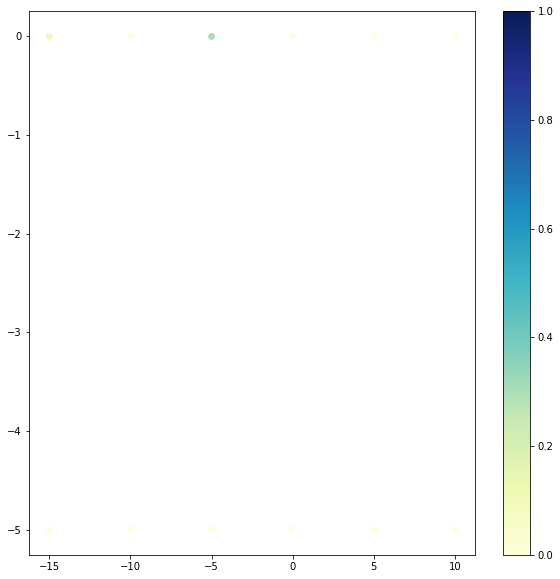

In [194]:
plot_scatter(position_x, position_y, avg_res)
#plt.savefig('scatter_roundOff.png')
#plt.show()

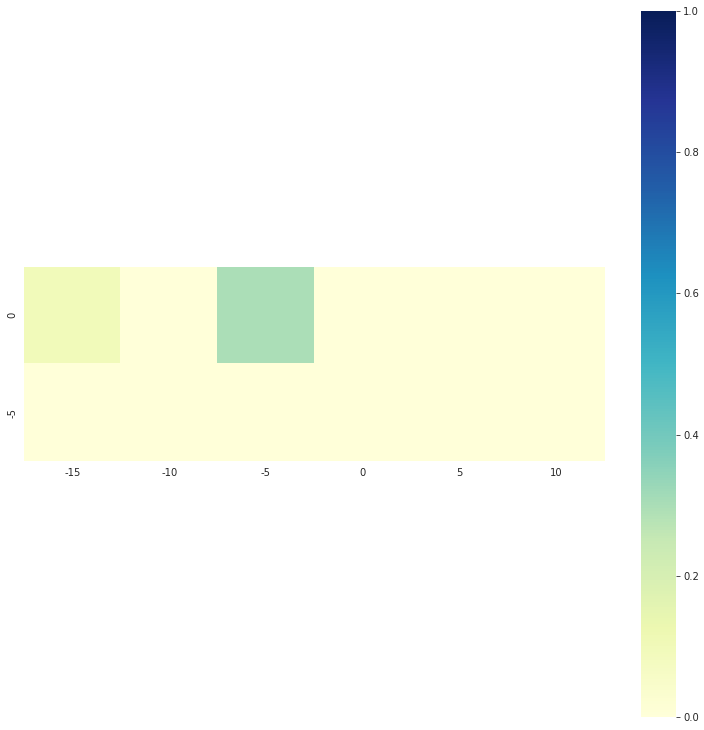

In [208]:
plot_hotmap(avg_res, mask)
#plt.savefig('hotmap_roundOff.png')

In [196]:
avg_res

array([[0.1, 0. , 0.3, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ]])

In [183]:
avg_res

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.1, 0.2],
       [0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0.3, 0.2, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 1. , 1. , 1. , 0.2, 0. , 0.1, 0. , 0. ],
       [0. , 1. , 1. , 0.9, 1. , 0.4, 0. , 0. , 0.1, 0.2],
       [0.9, 1. , 1. , 1. , 1. , 0.3, 0.1, 0.2, 0. , 0.1]])

In [156]:
def plot_scatter(x, y, res):
    fig = plt.figure(figsize=(10,10))
    sc = plt.scatter(x.ravel(), y.ravel(), c=res.ravel(), marker='o', vmin=0, vmax=1, s=35, cmap='YlGnBu')
    plt.colorbar(sc)

In [207]:
def plot_hotmap(data, mask):
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(13, 13))
        ax = sns.heatmap(data, mask=mask, vmax=1, square=True,  cmap="YlGnBu")
        ax.set_xticklabels(np.arange(-edge1, edge1, scale))
        ax.set_yticklabels(np.arange(edge2, -edge2, -scale) - scale)

# generate periodic points in triangle area
corrdinate = np.arange(0, edge, scale)
x,y = np.meshgrid(corrdinate, corrdinate)
starting_point = np.array(list(zip(x.ravel(),y.ravel())))
triangle = starting_point[starting_point[:,0] >= starting_point[:,1]]

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)

num = 300
points1 = sample_from_square([400,400], [200,200], num)
res1 = np.zeros((num, ))

for i in range(num):
    paras['mean0'] = points1[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp1.set_optimise(cma)
    status = exp1.do()
    if(status == 'global minimum'):
        res1[i] = 1
    else:
        res1[i] = 0

In [ ]:
pa2 = post_analysis_multi(points2, res2)
pa2.plot_cloud_point()

In [ ]:
pa2 = post_analysis_multi(points, res)
pa2.plot_prob_vs_radius()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
#exp1.analyser.print_mean_variance()

In [ ]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
line = line_search(alpha=2, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = line

cma2 = cma_es()
cma2.set_parameters(paras)

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)
exp2.set_optimise(cma2)
exp2.do()

In [ ]:
exp2.analyser.plot_distance()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro

cma3 = cma_es()
cma3.set_parameters(paras)

# boil down to one expreiment
exp3 = single_experiment()
exp3.set_objective(ak)
exp3.set_optimise(cma3)
exp3.do()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
l1 = line_search_1step(alpha=1, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = l1

cma4 = cma_es()
cma4.set_parameters(paras)

# boil down to one expreiment
exp4 = single_experiment()
exp4.set_objective(ak)
exp4.set_optimise(cma4)
exp4.do()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()